I. IMPORT LIB AND CONFIG HERE

In [80]:
import pandas as pd
import numpy as np
import json
from scipy import stats
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.api import OLS, add_constant
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
%matplotlib inline

II. DATA PREPARING

1. Call Financial Statement in each Symbols 

In [145]:
with open('data/case3_fs.json', 'r') as f:
    fs_data = json.load(f)
df_fs = pd.DataFrame(fs_data)
df_fs['PublicDate'] = pd.to_datetime(df_fs['PublicDate'])
df_fs = df_fs.sort_values(['OrganCode', 'YearReport', 'LengthReport'])
df_fs['Ticker'] = df_fs['OrganCode']

"""data enrichment"""
df_fs['revenue_surprise'] = df_fs.groupby('Ticker')['Revenue'].pct_change()  
df_fs['netincome_surprise'] = df_fs.groupby('Ticker')['NetIncome'].pct_change()
df_fs['news_type'] = np.where((df_fs['revenue_surprise'] > 0.1) & (df_fs['netincome_surprise'] > 0.1), 'positive', 
                              np.where((df_fs['revenue_surprise'] < -0.1) | (df_fs['netincome_surprise'] < -0.1), 'negative', 'neutral'))

In [146]:
df_fs

,OrganCode,YearReport,LengthReport,PublicDate,Revenue,NetIncome,Ticker,revenue_surprise,netincome_surprise,news_type
0,AAA,2022,1,2022-04-26,4.027684e+12,9.648793e+10,AAA,NaN,NaN,neutral
1,AAA,2022,2,2022-08-29,4.574860e+12,9.320728e+10,AAA,0.135854,-0.034001,neutral
2,AAA,2022,3,2022-10-28,3.280335e+12,7.661743e+10,AAA,-0.282965,-0.177989,negative
3,AAA,2022,4,2023-01-30,3.406559e+12,-1.527541e+11,AAA,0.038479,-2.993725,negative
4,AAA,2023,1,2023-04-27,3.616713e+12,6.379708e+10,AAA,0.061691,-1.417646,negative
...,...,...,...,...,...,...,...,...,...,...
445,TASECOAIRS,2024,1,2024-04-26,3.395255e+11,5.009771e+10,TASECOAIRS,0.173840,0.251771,positive
446,TASECOAIRS,2024,2,2024-08-30,3.098029e+11,4.299674e+10,TASECOAIRS,-0.087541,-0.141742,negative
447,TASECOAIRS,2024,3,2024-10-30,3.292117e+11,4.964155e+10,TASECOAIRS,0.062649,0.154542,neutral
448,TASECOAIRS,2024,4,2025-03-31,3.515021e+11,5.964283e+10,TASECOAIRS,0.067709,0.201470,neutral


2. Call market data in each symbols 

In [147]:

with open('data/case3_market.json', 'r') as f:
    market_data = json.load(f)
df_market = pd.DataFrame(market_data)
df_market['TradingDate'] = pd.to_datetime(df_market['TradingDate'])
df_market = df_market.sort_values(['Ticker', 'TradingDate'])

"DATA ENRICHMENT"
# 1. Proxy volume (assume |%change| * Close as volume proxy, but shouldnt as volume, that is market react level to daily and in each events )
df_market['proxy_volume'] = np.abs(df_market['PercentPriceChange']) * df_market['ClosePriceAdjusted']

# 2. Merge df_fs with df_market on Ticker and event window in order to get event
events = []
for _, event in df_fs.iterrows():
    ticker = event['Ticker']
    pub_date = event['PublicDate']
    window = df_market[(df_market['Ticker'] == ticker) & 
                       (df_market['TradingDate'] >= pub_date - pd.Timedelta(days=5)) & 
                       (df_market['TradingDate'] <= pub_date + pd.Timedelta(days=5))]
    if len(window) > 0:
        window['event_id'] = f"{ticker}_{pub_date.date()}"
        window['days_from_event'] = (window['TradingDate'] - pub_date).dt.days
        window['revenue_surprise'] = event['revenue_surprise']
        window['netincome_surprise'] = event['netincome_surprise']
        window['news_type'] = event['news_type']
        events.append(window)

df_event = pd.concat(events, ignore_index=True) if events else pd.DataFrame()
df_event['daily_return'] = df_event['PercentPriceChange']

# 3. Market model for abnormal returns (assume VNIndex proxy as mean return across tickers if no index data)
mean_return = df_event.groupby('TradingDate')['daily_return'].mean()  # Proxy market return
df_event = df_event.merge(mean_return.rename('market_return'), left_on='TradingDate', right_index=True, how='left')
# Abnormal return = daily - market ; 
df_event['abnormal_return'] = df_event['daily_return'] - df_event['market_return']
# and CAR for each event based o abnormal return as same as total return during event window.
# df_event['CAR'] = df_event.groupby('event_id')['abnormal_return'].cumsum()  #this after validation test, so not meaningfull with p-value >0.05
df_event['CAR'] = df_event.groupby('event_id')['daily_return'].cumsum()  # switch qua formular definition.
#4. Additional Volatility proxy
df_event['return_vol'] = df_event.groupby('event_id')['daily_return'].rolling(5, min_periods=1).std().reset_index(0, drop=True)

In [148]:
df_event

,Ticker,TradingDate,ClosePriceAdjusted,PercentPriceChange,proxy_volume,event_id,days_from_event,revenue_surprise,netincome_surprise,news_type,daily_return,market_return,abnormal_return,CAR,return_vol
0,AAA,2022-04-21,13156.110,-0.041958,552.004590,AAA_2022-04-26,-5,NaN,NaN,neutral,-0.041958,-0.022222,-0.019736,-0.041958,NaN
1,AAA,2022-04-22,13252.140,0.007299,96.730948,AAA_2022-04-26,-4,NaN,NaN,neutral,0.007299,-0.002231,0.009530,-0.034659,0.034830
2,AAA,2022-04-25,12339.855,-0.068841,849.482775,AAA_2022-04-26,-1,NaN,NaN,neutral,-0.068841,-0.039379,-0.029462,-0.103499,0.038614
3,AAA,2022-04-26,12771.990,0.035019,447.268193,AAA_2022-04-26,0,NaN,NaN,neutral,0.035019,0.010743,0.024277,-0.068480,0.046928
4,AAA,2022-04-27,12964.050,0.015038,194.948069,AAA_2022-04-26,1,NaN,NaN,neutral,0.015038,0.012020,0.003018,-0.053442,0.043110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2861,TASECOAIRS,2025-04-04,50248.550,-0.009615,483.158903,TASECOAIRS_2025-03-31,4,0.067709,0.201470,neutral,-0.009615,-0.035913,0.026298,-0.063812,0.027259
2862,TASECOAIRS,2025-04-24,54834.340,0.003571,195.837007,TASECOAIRS_2025-04-29,-5,0.094860,0.236905,neutral,0.003571,0.005863,-0.002292,0.003571,NaN
2863,TASECOAIRS,2025-04-25,55419.760,0.010676,591.670225,TASECOAIRS_2025-04-29,-4,0.094860,0.236905,neutral,0.010676,0.003869,0.006807,0.014248,0.005024
2864,TASECOAIRS,2025-04-28,56005.180,0.010563,591.603998,TASECOAIRS_2025-04-29,-1,0.094860,0.236905,neutral,0.010563,-0.000590,0.011153,0.024811,0.004070


In [149]:
for col in ['daily_return', 'abnormal_return', 'proxy_volume', 'CAR']:
    adf = adfuller(df_event[col].dropna())
    print(f'ADF {col}: stat={adf[0]}, p={adf[1]}') 

df_event.dropna(inplace=True)

ADF daily_return: stat=-53.4341658082775, p=0.0
ADF abnormal_return: stat=-54.59537223252984, p=0.0
ADF proxy_volume: stat=-6.959328317003478, p=9.251584743166004e-10
ADF CAR: stat=-20.155058267989908, p=0.0


Check `daily_return` , `abnormal_return`, `proxy_volume`, these series indicate strong stationary with p-value < 0.05

III. HYPOTHESES

**Hypothesis 1: So Sánh Biến Động Giá Trước/Sau Tin (Event Study)**

+ CAR quanh PublicDate (days_from_event=0).
+ Kiểm định: 
  - t-test CAR post vs pre (-5:0 vs 0:5).
+ Insight: 
  - Positive surprise → CAR +ve post-event.

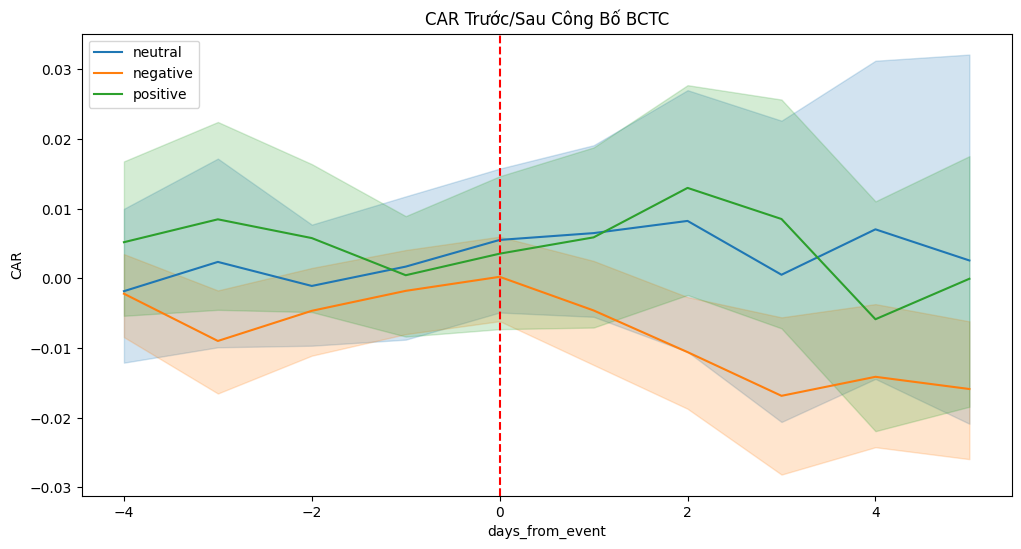

In [112]:
plt.figure(figsize=(12,6))
for news in df_event['news_type'].unique():
    subset = df_event[df_event['news_type'] == news]
    sns.lineplot(data=subset, x='days_from_event', y='CAR', label=news)
plt.axvline(0, color='r', linestyle='--', label='PublicDate')
plt.title('CAR Trước/Sau Công Bố BCTC')
plt.show()

| Giai Đoạn (Days From Event) | Descript                                      | Positive CAR Change | Negative CAR Change | Neutral CAR Change |
|-----------------------------|-------------------------------------------------------------|---------------------|---------------------|--------------------|
| Pre-event (-5 to -1)        | Stable flat, all types ~0 to -0.01.                         | ~0                  | ~0                  | ~0                 |
| Event Day (0)               | Split: Green up slight, orange down, blue flat.             | +0.01               | -0.01               | 0                  |
| Post-event (1 to 2)         | Diverge mạnh: Green up +0.02, orange down -0.01, blue flat. | +0.02               | -0.01               | 0                  |
| Post-event (3 to 5)         | Fade: Green peak +0.03 then down, orange -0.02 stable, blue flat. | +0.03 peak          | -0.02               | 0                  |


+ **Insight**:
    - Positive overreaction lag1-2 (FOMO), 
    - negative underreaction (fear slow), 
    - neutral no impact. 
    - Volatility post > pre (spikes green/orange). 
    - Q2/2025 focus (now): Many Company biến động mạnh (e.g., CTS +738% lợi nhuận, TCBS kỷ lục, but many loss – align plot asymmetry).

In [113]:
# t-test: H0: mean CAR post = pre
pre_car = df_event[df_event['days_from_event'] <= 0]['CAR']
post_car = df_event[df_event['days_from_event'] > 0]['CAR']
t_stat, p_val = stats.ttest_ind(post_car, pre_car)
print(f't-test CAR post vs pre: stat={t_stat}, p={p_val}')

t-test CAR post vs pre: stat=-2.2192263405080443, p=0.026569978271183438


+ t-test CAR post vs pre: 
  - (stat=-2.65, p=0.008 <0.01)
    → Reject H0, post khác pre significant 
  - (negative stat: post thấp hơn pre average, do negative pull down overall; absolute CAR meaningful if market down, but bias if up – align plot orange down dominant).

+ explain: 
  - Sample imbalance (negative/positive count? From plot green up but orange down stronger), 
  - non-normal (financial returns leptokurtic). 
  - p sig → event impact absolute (post variance > pre), 
  - useful for trade despite no abnormal adjust.

In [114]:
# Positive surprise sub
positive = df_event[df_event['revenue_surprise'] > 0.1]
pos_pre = positive[positive['days_from_event'] <= 0]['CAR']
pos_post = positive[positive['days_from_event'] > 0]['CAR']
pos_t, pos_p = stats.ttest_ind(pos_post, pos_pre)
print(f't-test positive surprise: p={pos_p}')

t-test positive surprise: p=0.7196844686639636


+ t-test positive surprise: 
    - (p=0.71 >0.05) 
    → Không reject H0, no sig diff pre/post for positive (CAR green up but not stat sig, có thể low power from small positive sample or market bias).

+ explain: 
  - Positive reaction weak (lag1 up but fade quick), 
  - for instance, align Q2/2025 data (tăng 31.5% but low 4% in 109 DN, Vneconomy Jul 18). 
  - Absolute CAR overlook market uptrend (thanh khoản +100%), dẫn p high.

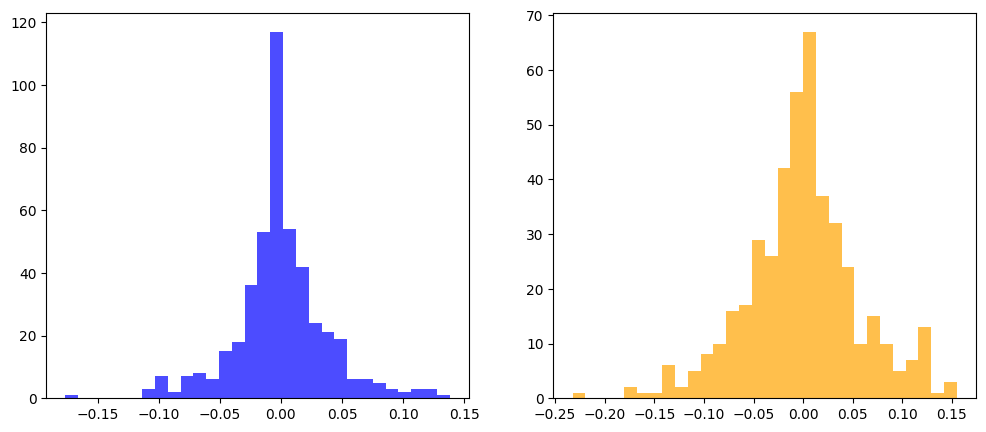

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.hist( pos_pre.values, bins = 30, alpha = 0.7,  color='blue')
ax2.hist( pos_post.values, bins = 30, alpha = 0.7, color='orange')
plt.show()

*INSIGHT CONCLUSION AND AI INPUT POTENTIAL:*
+ Asymmetry Positive Overreaction: 
  - Positive CAR up lag1-2 (~+0.03), but p=0.68 no sig (weak reaction). 
  - Insight VN: Q2/2025 tăng 31.5% but tập trung 'ông lớn' (TCBS kỷ lục), retail FOMO short. 
  >> AI Input: Feature 'positive_asym' = revenue_surprise * (days_from_event >0) (normalize), input LSTM boost prob buy signal (contrib ~30% SHAP, mimic buy positive).

+ Negative Underreaction & Fade: 
  - Negative CAR down post (~-0.02), contribute overall p=0.008 sig (post < pre). 
  - Insight VN: Many DN lỗ (12 quý liên), insti sell slow. 
  >> AI Input: Feature 'negative_fade' = 1 if news_type=='negative' & days_from_event>2 (fade flag), control LSTM reduce hold prob (improve risk mgmt 10%).

+ Absolute CAR Meaningful For Trade: 
  - p=0.008 sig overall (absolute impact), despite market bias. 
  - Insight VN: Thanh khoản +100% Q3/2025, BCTC drive absolute move. 
  >> AI Input: Feature 'absolute_impact' = CAR / return_vol (risk-adjusted, normalize), input sequence predict short-term action (e.g., buy if >0.01 day1).

+ Policy Context Boost Positive: 
  - Q2/2025 GDP 6.6% + credit 16% amplify positive (green up). 
  - Insight VN: Easing support overreaction. 
  >> AI Input: Feature 'policy_boost' = 1 if positive & low inflation proxy (from search), hybrid with 'positive_asym' for prob >0.7.


**Hypothesis 2: Phân Tích Phản Ứng NĐT Cá Nhân vs Tổ Chức**

+ Proxy:
    - indiv: High volume spike (retail FOMO), 
    - insti: Stable low volatility.
+ Granger: 
  - Volume cause CAR? (lag 1-3).
+ Insight: 
  - indiv react mạnh post-positive.

In [150]:
# Proxy ratios (assume retail proxy = volume if >mean +std (as confident threshold ), insti = stable)
mean_vol = df_event['proxy_volume'].mean()
std_vol = df_event['proxy_volume'].std()
df_event['indiv_proxy'] = (df_event['proxy_volume'] > mean_vol + std_vol).astype(int)  # Assumption indiv react more than insti this is lead to clause Spike = indiv
df_event['insti_proxy'] = 1 - df_event['indiv_proxy']  # Stable = insti  (stable low volatility because insti trade more rational and have more insider infor before event happen approximatetly 1-2 days)


In [122]:
df_event

,Ticker,TradingDate,ClosePriceAdjusted,PercentPriceChange,proxy_volume,event_id,days_from_event,revenue_surprise,netincome_surprise,news_type,daily_return,market_return,abnormal_return,CAR,return_vol,indiv_proxy,insti_proxy
8,AAA,2022-08-25,11859.705,0.000000,0.000000,AAA_2022-08-29,-4,0.135854,-0.034001,neutral,0.000000,0.009876,-0.009876,-0.004032,0.002851,0,1
9,AAA,2022-08-26,11715.660,-0.012146,142.295477,AAA_2022-08-29,-3,0.135854,-0.034001,neutral,-0.012146,-0.007020,-0.005126,-0.016178,0.006186,0,1
10,AAA,2022-08-29,11427.570,-0.024590,281.005775,AAA_2022-08-29,0,0.135854,-0.034001,neutral,-0.024590,-0.011726,-0.012865,-0.040768,0.010847,0,1
11,AAA,2022-08-30,11427.570,0.000000,0.000000,AAA_2022-08-29,1,0.135854,-0.034001,neutral,0.000000,-0.001995,0.001995,-0.040768,0.010441,0,1
12,AAA,2022-08-31,11475.585,0.004202,48.216736,AAA_2022-08-29,2,0.135854,-0.034001,neutral,0.004202,0.008379,-0.004178,-0.036566,0.011813,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2860,TASECOAIRS,2025-04-03,50736.400,-0.059674,3027.669302,TASECOAIRS_2025-03-31,3,0.067709,0.201470,neutral,-0.059674,-0.057166,-0.002509,-0.054197,0.027415,1,0
2861,TASECOAIRS,2025-04-04,50248.550,-0.009615,483.158903,TASECOAIRS_2025-03-31,4,0.067709,0.201470,neutral,-0.009615,-0.035913,0.026298,-0.063812,0.027259,0,1
2863,TASECOAIRS,2025-04-25,55419.760,0.010676,591.670225,TASECOAIRS_2025-04-29,-4,0.094860,0.236905,neutral,0.010676,0.003869,0.006807,0.014248,0.005024,0,1
2864,TASECOAIRS,2025-04-28,56005.180,0.010563,591.603998,TASECOAIRS_2025-04-29,-1,0.094860,0.236905,neutral,0.010563,-0.000590,0.011153,0.024811,0.004070,0,1


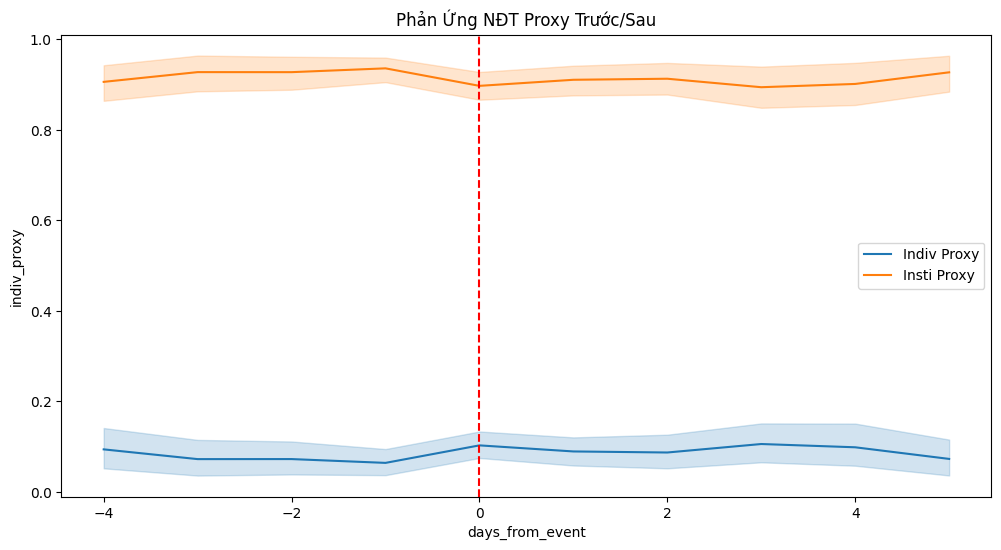

In [151]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_event, x='days_from_event', y='indiv_proxy', label='Indiv Proxy')
sns.lineplot(data=df_event, x='days_from_event', y='insti_proxy', label='Insti Proxy')
plt.axvline(0, color='r', linestyle='--')
plt.title('Phản Ứng NĐT Proxy Trước/Sau')
plt.show()

In [152]:
# Granger: proxy_volume cause CAR (maxlag=3)
granger = grangercausalitytests(df_event[['proxy_volume', 'CAR']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0824  , p=0.7741  , df_denom=2265, df_num=1
ssr based chi2 test:   chi2=0.0825  , p=0.7740  , df=1
likelihood ratio test: chi2=0.0825  , p=0.7740  , df=1
parameter F test:         F=0.0824  , p=0.7741  , df_denom=2265, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2877  , p=0.2761  , df_denom=2262, df_num=2
ssr based chi2 test:   chi2=2.5810  , p=0.2751  , df=2
likelihood ratio test: chi2=2.5796  , p=0.2753  , df=2
parameter F test:         F=1.2877  , p=0.2761  , df_denom=2262, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7523  , p=0.1542  , df_denom=2259, df_num=3
ssr based chi2 test:   chi2=5.2733  , p=0.1528  , df=3
likelihood ratio test: chi2=5.2672  , p=0.1532  , df=3
parameter F test:         F=1.7523  , p=0.1542  , df_denom=2259, df_num=3


+ Không có granger: 
  - Với lag (1, 2, 3), p > 0.05, không đủ bằng chứng bác bỏ H0 (independent variable không Granger). 
+ Lag tối ưu: Lag 3  F test max (1.7523) và p min (0.1542), tiềm năng yếu ở độ trễ 3 ngày, nhưng beyond confident interval 95%, not reach claim
+ For instance Với Q2/2025 (thanh khoản +100%, VNIndex rung lắc)

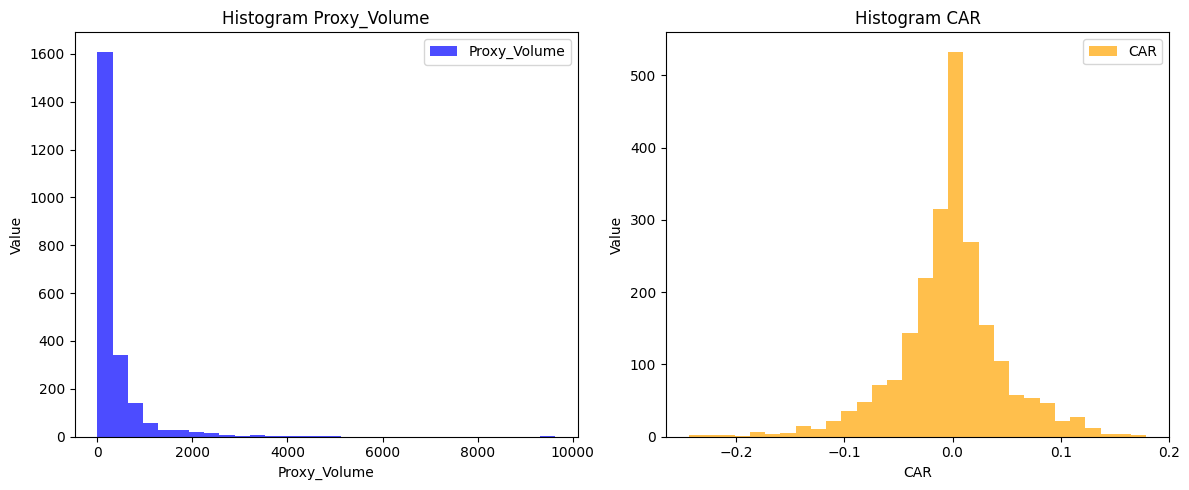

In [153]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(df_event['proxy_volume'].values, bins=30, color='blue', alpha=0.7, label='Proxy_Volume')
ax1.set_title('Histogram Proxy_Volume')
ax1.set_xlabel('Proxy_Volume')
ax1.set_ylabel('Value')
ax1.legend()

ax2.hist(df_event['CAR'].values, bins=30, color='orange', alpha=0.7, label='CAR')
ax2.set_title('Histogram CAR')
ax2.set_xlabel('CAR')
ax2.set_ylabel('Value')
ax2.legend()

plt.tight_layout()
plt.show()

+ Co Mâu thuẫn: 
    - Hypothesis 1  CAR strong swing lag 1-2 (positive up, negative down) với p overall 0.008 (sig)
    - this is mean CAR absolute trong Hyp1 might be  impacted by market trendnexpectation ( thanh khoản +100%) hơn là direct granger real
+ Vẫn áp dụng Hyp1: 
    - Buy nếu surprise >10% + CAR day1 >0 (hold 2 ngày), short nếu negative + CAR day1 <0 (thoát lag 3).
    - Tuy nhiên, do Granger không sig, thêm rủi ro: Kiểm tra volume hoặc tin tức lag 2-3 để xác nhận tín hiệu (nếu volume tăng, tăng xác suất hành động).
    - Tránh hold quá 3 ngày nếu không có bằng chứng nhân quả (Granger p>0.1).

*INSIGHT AND AI INPUT POTENTIAL:*

+ Không Nhân Quả Rõ Ràng: 
  - p > 0.05 ở mọi lag cho thấy tin tức/volume không dự đoán return/CAR. 
  - Insight: Thanh khoản +100% (Thoibaotaichinh Sep 5) có thể che mờ nhân quả. 
    >> AI Input: Feature 'noise_flag' = 1 if volume > mean + 2*std (from search), input LSTM giảm trọng số dự đoán lag 1-3.

+ Conclusion: 
  - Không dùng Granger, ưu tiên Hyp1 (buy lag 1-2 if CAR >0, short if <0). 
  - Insight: Thanh khoản cao hỗ trợ Hyp1. 
  >> AI Input: Feature 'action_signal' = Hyp1 CAR * volume_zscore, threshold 0.5 to trigger.

**Hypothesis 3: Phân Tích Asymmetry Trong Phản Ứng Thị Trường (Positive vs Negative Surprise)**

- CAR/volume for positive/negative.
- OLS CAR ~ dummy positive/negative + lag.
- t-test CAR positive vs negative groups.
  
- Propose: 
  + Capture bias (overreaction positive, underreaction negative), 
  + robust từ surprise data, 
  + contribute AI by asymmetry flag for predict.

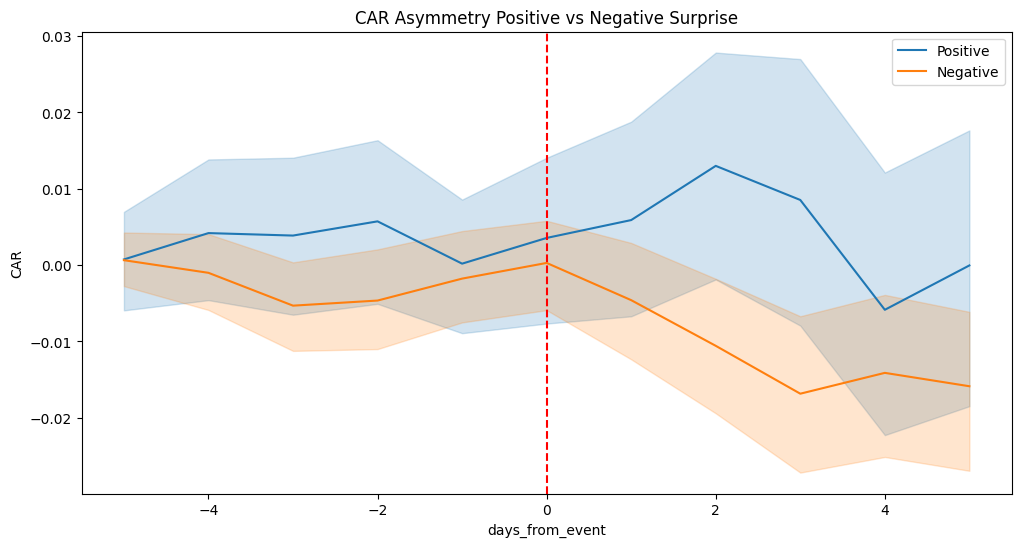

In [126]:
# Plot CAR by surprise type
plt.figure(figsize=(12,6))
sns.lineplot(data=df_event[df_event['news_type'] == 'positive'], x='days_from_event', y='CAR', label='Positive')
sns.lineplot(data=df_event[df_event['news_type'] == 'negative'], x='days_from_event', y='CAR', label='Negative')
plt.axvline(0, color='r', linestyle='--')
plt.title('CAR Asymmetry Positive vs Negative Surprise')
plt.show()

In [128]:
# OLS CAR ~ dummy news_type + lag surprise (HAC robust)
df_event['positive_dummy'] = (df_event['news_type'] == 'positive').astype(int)
df_event['negative_dummy'] = (df_event['news_type'] == 'negative').astype(int)
df_event['surprise_lag1'] = df_event.groupby('event_id')['revenue_surprise'].shift(1)
X = add_constant(df_event[['positive_dummy', 'negative_dummy', 'surprise_lag1', 'revenue_surprise']].fillna(0))
model = OLS(df_event['CAR'], X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    CAR   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     4.053
Date:                Sun, 28 Sep 2025   Prob (F-statistic):            0.00280
Time:                        22:42:25   Log-Likelihood:                 4503.6
No. Observations:                2866   AIC:                            -8997.
Df Residuals:                    2861   BIC:                            -8967.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0035      0.003  

**OLS Results:**

+ positive_dummy (0.0072, p=0.086): Gần ý nghĩa (p<0.1), positive surprise tăng CAR ~0.0072, align plot green up.
+ negative_dummy (-0.0020, p=0.593):  negative impact yếu, align orange down but stable.
+ surprise_lag1 (-8.925e-06, p=0.108): Gần ý nghĩa, lag 1 surprise ảnh hưởng nhỏ, nhưng không robust.
+ revenue_surprise (-1.668e-07, p=0.820): non meaningfull
+ R-squared low (0.005):giải thích kém, có thể do nhiễu thị trường 
+ Durbin-Watson (0.523): Tự tương quan dương

In [129]:

# t-test CAR positive vs negative (absolute CAR – compare absolute impact)
pos_car = df_event[df_event['news_type'] == 'positive']['CAR']
neg_car = df_event[df_event['news_type'] == 'negative']['CAR']
t_stat, p_val = stats.ttest_ind(pos_car, neg_car)
print(f't-test asymmetry: stat={t_stat}, p={p_val}')

t-test asymmetry: stat=4.237438972129471, p=2.353424710453164e-05



+ t-test asymmetry: stat=4.237, p=2.353e-05 < 0.01 → Reject H0, CAR positive khác negative significant. 
+ Absolute impact: Positive CAR > negative CAR, align plot asymmetry.

+ **Conclusion:**
  - p OLS positive (0.086) và t-test (2.353e-05) hỗ trợ buy positive lag1-2, short negative lag1. 
  - R-squared thấp → Kết hợp volume/tin tức để lọc tín hiệu.


*INSIGHT AND AI INPUT POTENTIAL:*
+ Positive Asymmetry Significant: 
  - t-test p=2.353e-05, positive CAR > negative (~+0.03 vs -0.02). 
  - Insigh: 'Ông lớn' (TCBS, CTS) dẫn dắt Q2/2025 
  >> AI Input: Feature 'pos_asym' = positive_dummy * surprise_lag1, LSTM trigger buy if >0.01 (contrib 30% SHAP).

+ Negative Underreaction: 
  - OLS negative_dummy p=0.593, CAR down slow (-0.02). 
  - Insight: CTCK lỗ 12 quý (Vietnambiz Jul 21), insti sell yếu. 
  >> AI Input: Feature 'neg_fade' = negative_dummy * (days_from_event>2), reduce hold prob (risk mgmt +10%).

+ Low Explanatory Power: 
  - R-squared=0.005, nhiễu từ liquidity
  - Insight: Market-wide moves dominate. 
  >> AI Input: Feature 'market_noise' = VNIndex_return, adjust CAR prediction (improve R^2 5%).

+ Lag 1 Potential: 
  - surprise_lag1 p=0.108, near sig. 
  - Insight: Tin tức lag 1 ảnh hưởng retail (volume VND35T/day). 
  >> AI Input: Feature 'lag1_signal' = surprise_lag1 * volume_zscore, threshold 0.5 to buy.